In [46]:
from gpt_batch.batcher import GPTBatcher
GPT_BASE_URL = "https://api.openai.com/v1"
GPT_API_KEY =""
model_name = "gpt-4o"
batcher = GPTBatcher(api_key=GPT_API_KEY, api_base_url=GPT_BASE_URL, model_name=model_name,num_workers=50)

In [47]:
import pandas as pd

# Define model configurations
models = [
    {
        "name": "LLaMa3-8B",
        "file": "Meta-Llama-3-8B-Instruct_seed_42_sample_num_500_few_shot_False_direct_io_False.json",
        "label_column": "meta-llama/Meta-Llama-3-8B-Instruct_label"
    },
    {
        "name": "LLaMa3-70B",
        "file": "Meta-Llama-3-70B-Instruct_seed_42_sample_num_500_few_shot_False_direct_io_False.json",
        "label_column": "meta-llama/Meta-Llama-3-70B-Instruct_label"
    },
    {
        "name": "GPT-4o",
        "file": "gpt-4o_seed_42_sample_num_100_few_shot_False_direct_io_False.json",
        "label_column": "gpt-4o_label"
    }
]

dataset_list = ["cladder", "copa", "corr2cause", "crab", "crass", "e_care", "moca", "pain", "tram"]

def process_model(model_config):
    list_error = []
    for dataset in dataset_list:
        file_list = f"./dataset/{dataset}/llm_result/"
        file_name = f"{file_list}{model_config['file']}"
        
        # Read case
        model_case = pd.read_json(file_name, lines=True, orient='records')
        model_case["pass"] = model_case["label"] == model_case[model_config['label_column']]
        model_case_error = model_case[model_case["pass"] == False]
        
        if len(model_case_error) > 100:
            model_case_error = model_case_error.sample(100, random_state=42)
        
        model_case_error["dataset"] = dataset
        model_case_error["model"] = model_config['name']
        list_error.append(model_case_error)
    
    model_error = pd.concat(list_error)
    model_error["answer"] = "My Prompt:" + model_error["prompt"] + "Model_answer:" + model_error[model_config['label_column']] + "The true answer is:" + model_error["label"]
    
    return model_error

# Read error classification prompt
with open("./prompt/error_analysis.txt", "r") as text_file:
    error_classify_prompt = text_file.read()

Error_analysis_prompt = '''
Now you are casual inference expert, I need you to anlysis the error of the model.
I will give four classes of error, you need to classify the error into these classes.
Here is description of the classes:
{error_classify_prompt}
Here is the error case:
## Prompt: {prompt}
## Model_answer: {model_answer}
## The true answer is: {true_answer}
Please diretly give me the answer class of the error case.
The answer could be #### Statistical Errors, #### Logical Errors, or #### Probabilistic Errors or #### Other Errors.
'''

# Process each model and store results
all_errors = []
for model in models:
    model_error = process_model(model)
    model_error["error_analysis"] = model_error.apply(lambda x: Error_analysis_prompt.format(
        error_classify_prompt=error_classify_prompt,
        prompt=x["prompt"],
        model_answer=x[model['label_column']],
        true_answer=x["label"]
    ), axis=1)
    all_errors.append(model_error)
    print(f"Completed error analysis for {model['name']}")

# Merge all errors into a single DataFrame
merged_errors = pd.concat(all_errors, ignore_index=True)

# You can now save the merged_errors DataFrame or perform further analysis
# For example, to save to a CSV file:
# merged_errors.to_csv("all_models_error_analysis.csv", index=False)

print("Error analysis completed for all models and results merged.")

Completed error analysis for LLaMa3-8B
Completed error analysis for LLaMa3-70B
Completed error analysis for GPT-4o
Error analysis completed for all models and results merged.


/tmp/ipykernel_1697620/2236472768.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_case_error["dataset"] = dataset
/tmp/ipykernel_1697620/2236472768.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_case_error["model"] = model_config['name']
/tmp/ipykernel_1697620/2236472768.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.o

In [49]:
question_list = merged_errors["error_analysis"]
reposne_list = batcher.handle_message_list(question_list)

Processing messages: 100%|██████████| 30/30 [07:39<00:00, 15.32s/it]


In [50]:
def parse_error_analysis(response):
    response = response.split("####")[1:]
    response ="".join(response)
    error_classes = ["Statistical Errors","Logical Errors","Probabilistic Errors","Other Errors"]
    for error_class in error_classes:
        if error_class in response:
            return error_class
    return "None"
merged_errors["error_analyis_response"] = reposne_list
merged_errors["error_class"] = merged_errors["error_analyis_response"].apply(parse_error_analysis)
merged_errors["error_class"].value_counts()

error_class
Logical Errors          1323
Probabilistic Errors     134
Statistical Errors        27
Other Errors               8
None                       5
Name: count, dtype: int64

In [51]:
merged_errors.to_csv("all_models_error_analysis.csv", index=False)

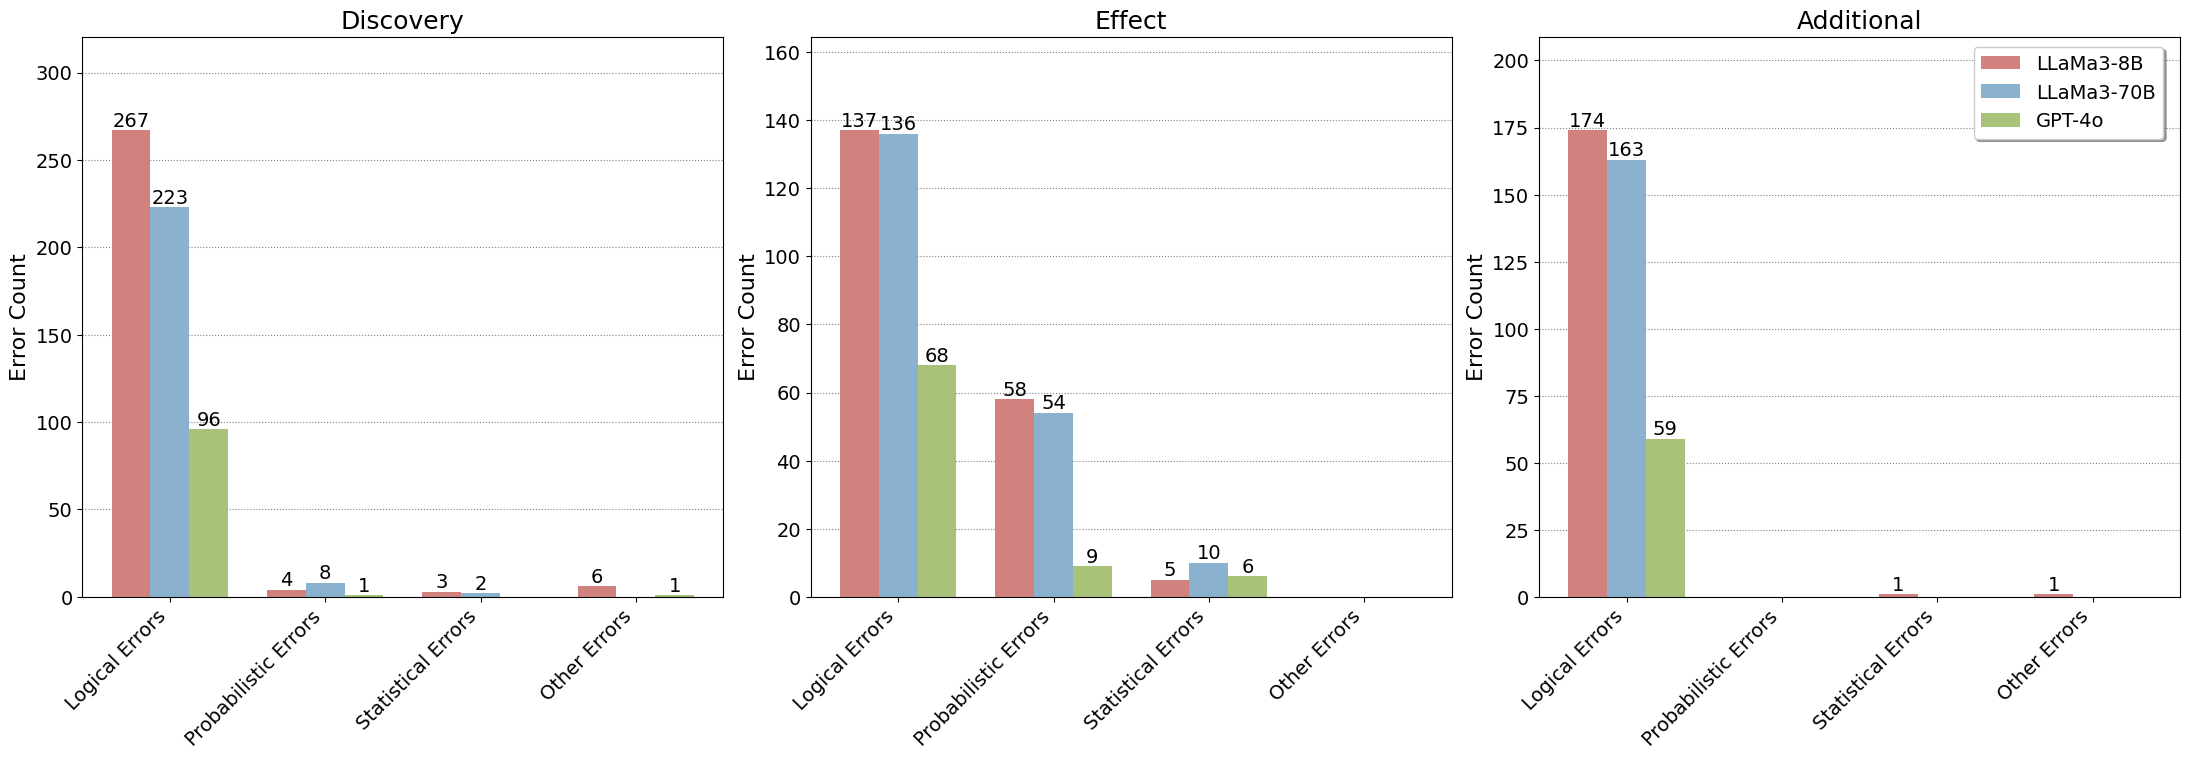

In [4]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Assuming merged_errors is your existing DataFrame
# Data definitions
merged_errors = pd.read_csv("all_models_error_analysis.csv")
dataset_mapping = {
    'Discovery': ['copa', 'e_care', 'corr2cause', 'pain'],
    'Effect': ['cladder', 'crab'],
    'Additional': ['crass', 'moca', 'tram']
}
models = ["LLaMa3-8B", "LLaMa3-70B", "GPT-4o"]
error_classes = ['Logical Errors', 'Probabilistic Errors', 'Statistical Errors','Other Errors' ]

# Color mapping for models
colors = {'LLaMa3-8B': '#d2827e', 'LLaMa3-70B': '#8ab1cd', 'GPT-4o': '#a9c279'}

# Set up the plot
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(22, 8))
#fig.suptitle('Error Analysis for Different Model Categories', fontsize=20)

# Function to plot for each category
def plot_category(ax, category, data):
    datasets = dataset_mapping[category]
    category_data = data[data['dataset'].isin(datasets)]
    x = np.arange(len(error_classes))
    width = 0.25
    
    for i, model in enumerate(models):
        model_data = category_data[category_data['model'] == model]
        error_counts = [model_data[model_data['error_class'] == error_class].shape[0] for error_class in error_classes]
        ax.bar(x + i*width, error_counts, width, label=model, color=colors[model])
        
        # Add value labels on top of each bar
        for j, v in enumerate(error_counts):
            if v > 0:
                ax.text(x[j] + i*width, v, str(v), ha='center', va='bottom', fontsize=14)
    
    ax.set_title(category, fontsize=18)
    ax.set_xticks(x + width)
    ax.set_xticklabels(error_classes, rotation=45, ha='right', fontsize=14)
    ax.set_xlabel('', fontsize=14)
    ax.set_ylabel('Error Count', fontsize=16)
    ax.set_ylim(0, category_data.groupby(['model', 'error_class']).size().max() * 1.2)  # Adjust y-axis limit
    
    # Add dotted horizontal lines
    ax.yaxis.grid(True, linestyle=':', color='gray')
    ax.set_axisbelow(True)
    
    # Increase tick label font size
    ax.tick_params(axis='both', which='major', labelsize=14)

# Plot for each category
plot_category(ax1, 'Discovery', merged_errors)
plot_category(ax2, 'Effect', merged_errors)
plot_category(ax3, 'Additional', merged_errors)

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(top=0.85, bottom=0.15)

# Create a single legend for the entire figure and place it in the upper right
handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(0.99, 0.85),
           ncol=1, fancybox=True, shadow=True, fontsize=14)

plt.show()

In [80]:
other_errors = merged_errors[merged_errors["error_class"]=="Other Errors"][["error_analysis","error_analyis_response"]]
other_errors.to_csv("other_errors.csv", index=False)